# Progressive Resizing

In [ ]:
from fastai.vision.all import *
from plant_pathology.all import *

In [ ]:
resizing_schedule = [{"pre": 800, }]

## Check that DLs at diff. sizes look good

In [ ]:
dls = get_dls_all_in_1(presize=800, resize=128, bs=400)

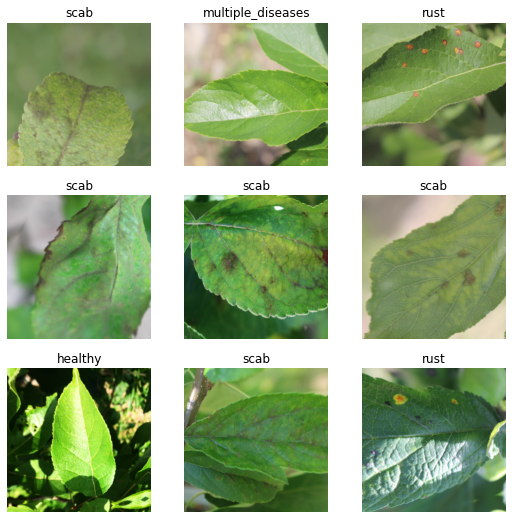

In [ ]:
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[accuracy, RocAuc()])

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0008317637839354575)

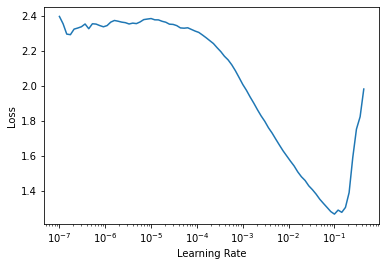

In [ ]:
learn.lr_find()

In [ ]:
learn.dls.train.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> RandomResizedCropGPU -- {'size': (256, 256), 'min_scale': 0.5, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0} -> Brightness -- {'max_lighting': 0.30000000000000004, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

Looks like we are already normalizing to imagenet stats.

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,1.553339,1.789237,0.706849,0.857909,00:41


In [ ]:
train(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,3.146428,3463.427490,0.282192,0.500000,00:43


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,2.760866,6273.840332,0.052055,0.500000,00:42


## Train w/ DLs of different sizes

Train most epochs at small sizes, some at medium, and then less on very largest sizes. Also, treat each level as transfer learning (i.e. find lr, train head, then train whole model (fine_tune)).

In [ ]:
MixUp??

Init signature: MixUp(alpha=0.4)
Docstring:      Basic class handling tweaks of the training loop by changing a `Learner` in various events
Source:        
class MixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,sel